# Demo RNA  usando Auto-Keras para procesar imágenes e identificar la clase que corresponde
Fuente:https://autokeras.com/

( *No se usa GPU porque tira error de memoria * )

In [1]:
#@title Instalar Auto-Keras 
#!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install keras-tuner --upgrade
!pip install autokeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.4/162.4 KB 8.7 MB/s eta 0:00:00


In [7]:
#@title Librerías a usar
import autokeras as ak

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


In [8]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


In [9]:
#@title Cargar imágenes


#@markdown ### Parámetros de imágenes:
imagen_ancho = 24 #@param {type:"integer"}
imagen_largo = 24 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
incluir_imagenes_generadas_con_data_augmentation = True #@param {type:"boolean"}


# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# indica si se usan las imágenes generadas por data augmentation
usarDA = incluir_imagenes_generadas_con_data_augmentation


# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            if usarDA or (not esImagDA): 
                
                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)
                
                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:              
                  tipoImage = 'L'
                else:                
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
                
                # transforma a un vector de nros
                arImag = np.array(imag)
                
                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  240
- Ejemplo  0   (24, 24, 3) : 




> Para Prueba: 
- Clases cargadas:  10
- Imágenes cargadas:  60
- Ejemplo  0   (24, 24, 3) : 


In [10]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) & 
        (img[:, :, 1] == 0) & 
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro 
        # (para que no cambié después) 
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (240, 24, 24, 3)
 - y_trainEnc (cant):  240
 - y_train (cant):  240


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (60, 24, 24, 3)
 - y_testEnc (cant):  60
 - y_test (cant):  60


> Para Ambos: 
 - dictMapeo:  {'5': 0, '7': 1, '8': 2, '1': 3, '6': 4, '0': 5, '9': 6, '4': 7, '3': 8, '2': 9}
 - clases_map:  ['5', '7', '8', '1', '6', '0', '9', '4', '3', '2']

 - Imagen reconstruida de  0 ( 5  /  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] )


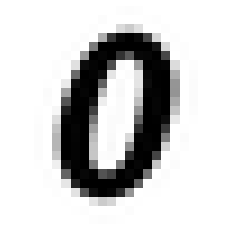

In [11]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
##  auxiAr = np.array(imagList).astype('float32') / 255.
##  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  auxiAr = np.array(imagList)
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))  
  return auxiAr

  return np.array(auxiAr)

# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

daLayers_modelo = []

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

In [12]:
#@title Establecer modelo base para AutoKeras


cantidad_intentos_encontrar_modelo = 5 #@param {type:"integer"}
if cantidad_intentos_encontrar_modelo < 1:
  cantidad_intentos_encontrar_modelo = 1

tipo_modelo_usar = "Personalizado" #@param ["ImageClassifier", "Personalizado"]

max_cant_params_modelo =  50000000#@param {type:"integer"}
if max_cant_params_modelo <= 0:
  max_cant_params_modelo = None
#@markdown   (Nota: se limita la complejidad el modelo a usar para evitar problemas por limitación de memoria RAM.)

# AutoKeras siempre se usa salida softmax 
# (se puede usar salida lineal pero lo aplica el pipeline,
#  no el modelo que se exporta)
tipo_output_softMax = True

if tipo_modelo_usar == "ImageClassifier":
    # Initialize the image classifier.
    AKmodel = ak.ImageClassifier(num_classes=len(clases_map), 
                                          overwrite=True, 
                                          seed=1,
                                          objective='val_accuracy',
                                          max_model_size=max_cant_params_modelo,
                                          max_trials=cantidad_intentos_encontrar_modelo)
else:
    # capa de entrada
    input_node = ak.ImageInput()
    # capas intermedias
    output_node = ak.ImageBlock(
        # Only search ConvNet architectures.
        block_type="vanilla",
        # Normalize the dataset.
        normalize=True,
        # Allow do data augmentation.
        augment=True,
    )(input_node)
    # capa de salida
    output_node = ak.ClassificationHead(num_classes=len(clases_map))(output_node)
    # Initialize AutoModel personalizado
    AKmodel = ak.AutoModel(
        inputs=input_node, outputs=output_node,          
        overwrite=True, 
        seed=1,
        objective='val_accuracy',
        max_model_size=max_cant_params_modelo,
        max_trials=cantidad_intentos_encontrar_modelo)

print("Modelo preparado")


Modelo preparado


In [13]:
#@title Entrenar con AutoKeras


max_epocas_entrenamiento =  300#@param {type:"integer"}
if max_epocas_entrenamiento <= 0:
  max_epocas_entrenamiento = None


# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# el history sólo devuelve el del último trial
#history = 
AKmodel.fit(x_t, y_t,
                      validation_data=(x_v, y_v,),
                      epochs=max_epocas_entrenamiento
                      )

print("\n>Entrenamiento Finalizado.")


Trial 5 Complete [00h 00m 45s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 18s


Epoch 1/300


7/7 [==============================] - 3s 86ms/step - loss: 2.4774 - accuracy: 0.0741 - val_loss: 2.3055 - val_accuracy: 0.0000e+00
Epoch 2/300
7/7 [==============================] - 0s 63ms/step - loss: 2.3019 - accuracy: 0.1065 - val_loss: 2.3166 - val_accuracy: 0.0000e+00
Epoch 3/300
7/7 [==============================] - 0s 61ms/step - loss: 2.2960 - accuracy: 0.1435 - val_loss: 2.3209 - val_accuracy: 0.0417
Epoch 4/300
7/7 [==============================] - 0s 54ms/step - loss: 2.2844 - accuracy: 0.1481 - val_loss: 2.3410 - val_accuracy: 0.0833
Epoch 5/300
7/7 [==============================] - 0s 58ms/step - loss: 2.1313 - accuracy: 0.2315 - val_loss: 2.0856 - val_accuracy: 0.1250
Epoch 6/300
7/7 [==============================] - 0s 58ms/step - loss: 2.1400 - accuracy: 0.1991 - val_loss: 2.0898 - val_accuracy: 0.2083
Epoch 7/300
7/7 [==============================] - 0s 55ms/step - loss: 1.9528 - accuracy: 0.2593 - val_loss: 1.3901 - val_accuracy: 0.6667
Epoch 8/300
7/7 [=======


>Entrenamiento Finalizado.


In [14]:
 #@title Mostrar Resumen de las Pruebas realizadas por AutoKeras
 print(AKmodel.tuner.results_summary())

resEval = AKmodel.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Mejor Modelo con datos de Prueba: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

Results summary
Results in ./auto_model
Showing 10 best trials
Trial summary
Hyperparameters:
image_block_1/image_augmentation_1/translation_factor: 0.1
image_block_1/image_augmentation_1/horizontal_flip: True
image_block_1/image_augmentation_1/vertical_flip: True
image_block_1/image_augmentation_1/rotation_factor: 0.0
image_block_1/image_augmentation_1/zoom_factor: 0.0
image_block_1/image_augmentation_1/contrast_factor: 0.0
image_block_1/conv_block_1/kernel_size: 3
image_block_1/conv_block_1/separable: False
image_block_1/conv_block_1/max_pooling: True
image_block_1/conv_block_1/num_blocks: 2
image_block_1/conv_block_1/num_layers: 2
image_block_1/conv_block_1/filters_0_0: 32
image_block_1/conv_block_1/filters_0_1: 32
image_block_1/conv_block_1/dropout: 0.0
image_block_1/conv_block_1/filters_1_0: 32
image_block_1/conv_block_1/filters_1_1: 32
classification_head_1/spatial_reduction_1/reduction_type: flatten
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 0.01
Score: 1.0


2/2 [==============================] - 0s 13ms/step - loss: 0.3656 - accuracy: 0.8833

>Evaluación del Mejor Modelo con datos de Prueba: 
    - Error:  0.36564934253692627
    - Exactitud:  88.33333253860474




In [15]:
#@title Exportar Modelo y Re-Entrenar (opcional)

reentrenar_modelo = False #@param {type:"boolean"}

cant_epocas_reentrenamiento =  500#@param {type:"integer"}
if cant_epocas_reentrenamiento <= 0:
  cant_epocas_reentrenamiento = None


# exporta el modelo y lo muestra
print("\n>> Mejor modelo generado: ")
model = AKmodel.export_model()
model.summary()
print("")

if reentrenar_modelo: 
  # realiza el re-entrenamiento del modelo
  print("\n\n>Comienza el Re-Entrenamiento:")
  history = model.fit(x_t, y_t,
                        validation_data=(x_v, y_v,),
                        epochs=cant_epocas_reentrenamiento
                        )
  print("\n>Re-Entrenamiento Finalizado.")


>> Mejor modelo generado: 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 24, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 24, 24, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 24, 24, 3)        7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 24, 24, 3)        0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 24, 24, 3)         0         
                                                             

In [16]:
#@title Probar red entrenada con datos de entrenamiento
mostrar_detalle_imagenes_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map, mostrarImagenes=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )

        # sólo muestra las imágenes no generadas por DA
        if mostrarImagenes:
          strTitulo = 'Real: ' + clReal + ' / RNA: ' 
          strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

          # muestra comparación con la imagen
          fig = plt.figure()
          fig.suptitle( strTitulo )
          ax1 = fig.add_subplot(121)
          plot_image( x[i] )
          
          plt.tight_layout()
          fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\n Matriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)    
    print(cmtx)
    print("\n")

    if mostrarImagenes:
      print("\n>Resultados: ")


# prueba con los datos de prueba
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, esDAimag_train, clases_map, mostrar_detalle_imagenes_entrenamiento)

*** Resultados con datos de Entrenamiento: 
8/8 [==============================] - 0s 11ms/step

 Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.92      1.00      0.96        24
           2       1.00      0.96      0.98        24
           3       1.00      0.83      0.91        24
           4       0.96      0.96      0.96        24
           5       0.86      1.00      0.92        24
           6       0.83      0.62      0.71        24
           7       1.00      0.96      0.98        24
           8       0.96      1.00      0.98        24
           9       0.70      0.88      0.78        24

    accuracy                           0.92       240
   macro avg       0.92      0.92      0.92       240
weighted avg       0.92      0.92      0.92       240


 Matriz de Confusión ( real / modelo ): 
     m:0  m:1  m:2  m:3  m:4  m:5  m:6  m:7  m:8  m:9
r:0   23    0    0  

In [17]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_imagenes_prueba = False #@param {type:"boolean"}
 
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, esDAimag_test, clases_map, mostrar_detalle_imagenes_prueba)

2/2 [==============================] - 0s 15ms/step - loss: 0.3656 - accuracy: 0.8833

>Evaluación del Modelo: 
    - Error:  0.36564934253692627
    - Exactitud:  88.33333253860474




*** Resultados con datos de Prueba: 
2/2 [==============================] - 0s 15ms/step

 Reporte de Clasificación: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.67      0.80         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       0.75      0.50      0.60         6
           7       0.86      1.00      0.92         6
           8       0.75      1.00      0.86         6
           9       0.57      0.67      0.62         6

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88   